In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget

In [2]:
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
from methods import *
from plotting_functions import *

In [3]:
class GridPhases(torch.nn.Module):
    """
    torch model for learning optimal grid cell phases
    """
    def __init__(self, ncells=3, f=1, init_rot=0, dtype=torch.float32, **kwargs):
        super(GridPhases, self).__init__(**kwargs)
        # init static grid properties
        self.ncells, self.f, self.init_rot, self.dtype = ncells, f, init_rot, dtype
        rotmat_init = rotation_matrix(init_rot)
        rotmat_60 = rotation_matrix(60)
        k1 = np.array([1.0, 0.0])
        k1 = rotmat_init @ k1
        ks = np.array([np.linalg.matrix_power(rotmat_60, k) @ k1 for k in range(3)])
        ks = torch.tensor(ks, dtype=dtype)
        self.ks = ks * f * 2 * np.pi
        # init trainable phases
        inner_hexagon = Hexagon(f/np.sqrt(3),init_rot,np.zeros(2))
        phases = inner_hexagon.sample(ncells)
        self.phases = torch.nn.Parameter(torch.tensor(phases,dtype=dtype,requires_grad=True))
        self.relu = torch.nn.ReLU()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        
    def forward(self, r, rectify=False, unit_scale=False, cells_first=False):
        phases = self.phases
        for _ in range(r.ndim - 1):
            # expand phases to include the spatial dims given by r
            phases = phases[:,None]
        r = r[None] # empty dim for number of phases/grid cells
        activity = torch.cos((r - phases) @ self.ks.T)
        activity = torch.sum(activity, axis=-1) # sum plane waves
        activity = self.relu(activity) if rectify else activity
        if unit_scale:
            activity -= torch.amin(activity,dim=tuple(range(1,activity.ndim)),keepdims=True)
            activity /= torch.amax(activity,dim=tuple(range(1,activity.ndim)),keepdims=True)
        return activity if cells_first else torch.permute(activity, tuple(list(range(1,len(activity.shape))) + [0]))
    
    def jacobian(self, r):
        phases = self.phases
        for _ in range(r.ndim - 1):
            # expand phases to include the spatial dims given by r
            phases = phases[:,None]
        J_tmp = -torch.sin((r - phases) @ self.ks.T)
        Jx = torch.sum(J_tmp * self.ks[:,0],axis=-1)
        Jy = torch.sum(J_tmp * self.ks[:,1],axis=-1)
        Jx = torch.transpose(Jx,0,-1)
        Jy = torch.transpose(Jy,0,-1)
        J = torch.stack([Jx,Jy],axis=-1)
        return J
    
    def the_jacobian(self, J, sqrt=True):
        """
        Parameters:
            J (f1, f2, ..., fn, ncells, 2)
        """
        det = torch.linalg.det(torch.transpose(J, -2, -1) @ J)
        return torch.sqrt(det) if sqrt else det
    
    def loss_fn(self, the_jacobian):
        return torch.var(the_jacobian,unbiased=True)
    
    def train_step(self, r):
        self.optimizer.zero_grad(set_to_none = True)
        J = self.jacobian(r)
        the_jacobian = self.the_jacobian(J)
        loss = self.loss_fn(the_jacobian)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def ratemaps_from_board(self, board):
        ratemaps1d = self(board.reshape(-1,2)).detach().numpy()
        ratemaps2d = ratemaps1d.reshape(*[int(np.sqrt(ratemaps1d.shape[0]))]*2,-1)
        return ratemaps1d, ratemaps2d
    
    def imshow_ratemaps(self, board, fig=None, axs=None):
        ratemaps1d, ratemaps2d = self.ratemaps_from_board(board)
        if axs is None:
            fig,axs = plt.subplots(ncols=ratemaps2d.shape[-1])
            [axs[i].imshow(ratemaps2d[...,i]) for i in range(len(axs))]
            [axs[i].axis('off') for i in range(len(axs))]
        return fig, axs
    
    def show_jacobian_det(self,r,fig=None,ax=None):
        det = self.the_jacobian(self.jacobian(r)).detach().numpy()
        if ax is None:
            fig,ax=plt.subplots()
        im = ax.imshow(det)
        ax.axis('off')
        fig.colorbar(im)
        ax.set_title(f"{np.min(det):.2f}, {np.max(det):.2f}, {np.std(det):.2f}")
        return fig, ax

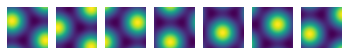

In [4]:
nx,ny = 1.2,1.2 # board size
res = 100

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)
board = torch.tensor(board,dtype=torch.float32)
# Init model
model = GridPhases(7)
# show cells
model.imshow_ratemaps(board);

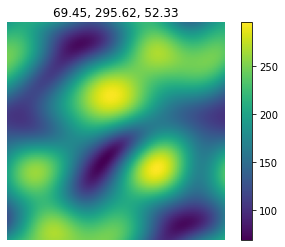

In [5]:
model.show_jacobian_det(board);

100%|████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 426.27it/s]


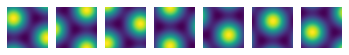

In [6]:
# Train model
loss_history = []
phases_history = [model.phases.clone().detach().numpy()]
for epoch in tqdm.trange(2000):
    loss = model.train_step(board.reshape(-1,2))
    loss_history.append(loss)
    phases_history.append(model.phases.clone().detach().numpy())
model.imshow_ratemaps(board);

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'207.26, 207.26, 0.00'}>)

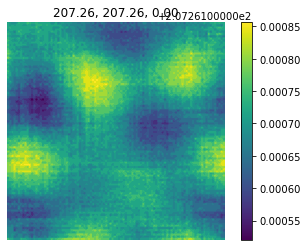

In [7]:
model.show_jacobian_det(board)

3.7125997831566337e-09

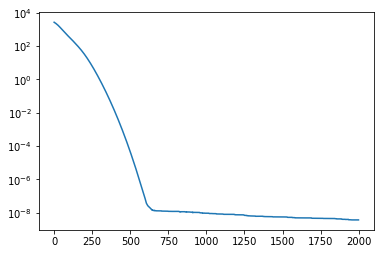

In [8]:
plt.plot(loss_history)
plt.semilogy()
loss_history[-1]

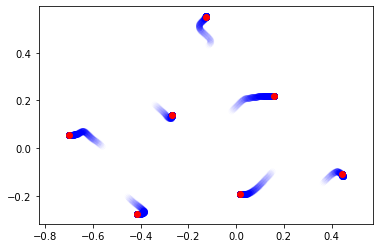

In [9]:
N = len(phases_history)
[plt.scatter(*phases_history[i].T, c='blue', alpha=i/N) for i in range(N)]
plt.scatter(*phases_history[-1].T, c='red')
plt.axis('equal');

In [10]:
phases_history[-1]

array([[-0.41369474, -0.27520043],
       [-0.6994087 ,  0.05471407],
       [ 0.44344804, -0.11024319],
       [-0.12798044,  0.5495859 ],
       [ 0.15773374,  0.2196713 ],
       [ 0.01487673, -0.1927218 ],
       [-0.27083758,  0.1371927 ]], dtype=float32)

In [11]:
ratemaps1d, _ = model.ratemaps_from_board(board)
if model.ncells > 3:
    import umap
    projection = umap.UMAP(n_components=3)
    out = projection.fit_transform(ratemaps1d)
else:
    out = ratemaps1d

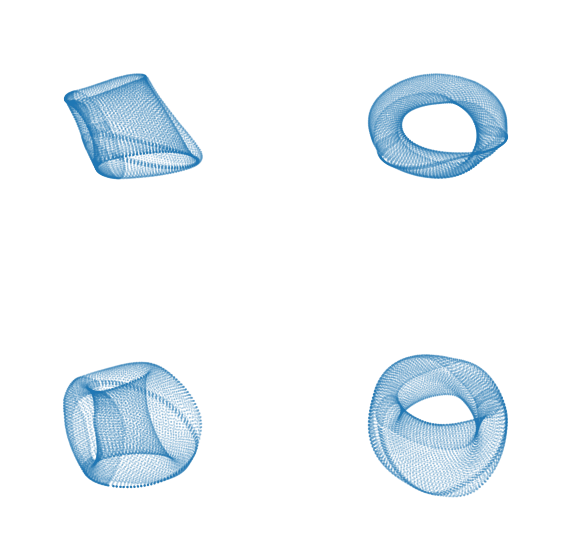

In [12]:
scatter3d(out,ncols=2,nrows=2,azim_elev_title=False,figsize=(10,10),alpha=0.2);

In [13]:
from ripser import ripser
from persim import plot_diagrams

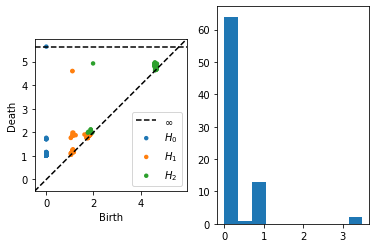

In [14]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g,maxdim=2,n_perm=150)['dgms']
dgms = ripser(ratemaps1d,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
axs[1].hist(dgms[1][:,1] - dgms[1][:,0]);